# 1. Dataset

In [1]:
import pandas as pd

## 1.1. Cargar el dataset

In [2]:
uri = 'https://raw.githubusercontent.com/maribcs/mgp-bayesian-network-retail/main/data/db_mgp_t1.csv'
df = pd.read_csv(uri, sep=",")
df.head()

,row_num,flag_nuevo,fl_omni,fl_fcom,fl_tienda,flag_tienetarjeta,flag_metodopago,flag_tienepromocion,Genero,NSE,Rango_edad,estado_marital,flag_tiene_hijo,rango_gasto
0,27,1,0,0,1,0,0,0,M,C,26-35 AÑOS,C,1,gasto bajo
1,36,1,0,0,1,0,0,0,F,B,36-45 AÑOS,C,0,gasto alto
2,62,1,0,0,1,1,1,0,F,B,26-35 AÑOS,S,0,gasto medio
3,65,0,0,0,1,0,0,0,M,C,36-45 AÑOS,C,1,gasto bajo
4,99,0,0,0,1,1,0,0,F,B,36-45 AÑOS,S,0,gasto alto


In [4]:
# Tamaño del dataset
df.shape

(990392, 14)

## 1.2. Prepocesar el dataset

In [58]:
# Seleccionar columnas a utilizar
df_modelo = df[['NSE','Rango_edad','Genero','estado_marital','flag_tienetarjeta','flag_nuevo','flag_metodopago','flag_tienepromocion','fl_fcom','rango_gasto']]

In [59]:
# Renombrar columnas

# 1. NSE: Nivel socioeconómico
# 2. E: Edad
# 3. G: Género
# 4. EC: Estado civil
# 5. TR: Tiene o no tarjeta del retail
# 6. TC: Tipo de cliente
# 7. MP: Método de pago
# 8. PP: Producto en promoción o no
# 9. CC: Canal de compra tienda / web
# 10. C: Compra

df_modelo = df_modelo.rename(columns = {'Rango_edad':'E','Genero':'G','estado_marital':'EC','flag_tienetarjeta':'TR','flag_nuevo':'TC','flag_metodopago':'MP','flag_tienepromocion':'PP','fl_fcom':'CC','rango_gasto':'C'})
df_modelo.head()

,NSE,E,G,EC,TR,TC,MP,PP,CC,C
0,C,26-35 AÑOS,M,C,0,1,0,0,0,gasto bajo
1,B,36-45 AÑOS,F,C,0,1,0,0,0,gasto alto
2,B,26-35 AÑOS,F,S,1,1,1,0,0,gasto medio
3,C,36-45 AÑOS,M,C,0,0,0,0,0,gasto bajo
4,B,36-45 AÑOS,F,S,1,0,0,0,0,gasto alto


In [60]:
# NSE
df_modelo['NSE'] = df_modelo['NSE'].replace({'A':0,'B':1,'C':2,'D':3,'E':4})
# Edad
df_modelo['E'] = df_modelo['E'].replace({'16-25 AÑOS':0,'26-35 AÑOS':1,'36-45 AÑOS':2,'46-55 AÑOS':3,'56 A MÁS':4})
# Genero
df_modelo['G'] = df_modelo['G'].replace({'M':0,'F':1})
# Estado civil
df_modelo['EC'] = df_modelo['EC'].replace({'S':0,'C':1})
# Monto compra
df_modelo['C'] = df_modelo['C'].replace({'gasto bajo':0,'gasto medio':1,'gasto alto':2})


# 2. Modelo

In [11]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.6 MB/s eta 0:00:00


In [166]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import TreeSearch
from pgmpy.inference import VariableElimination

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## 2.1. Definición de nodos

In [61]:
model = BayesianNetwork([('NSE', 'TR'), ('TR', 'MP'), ('MP', 'PP'), ('CC', 'PP'),('PP', 'C'),('CC', 'C'),('E', 'TC'),('G', 'TC'),('EC', 'TC'),('TC', 'C')])

## 2.2. DAG del modelo

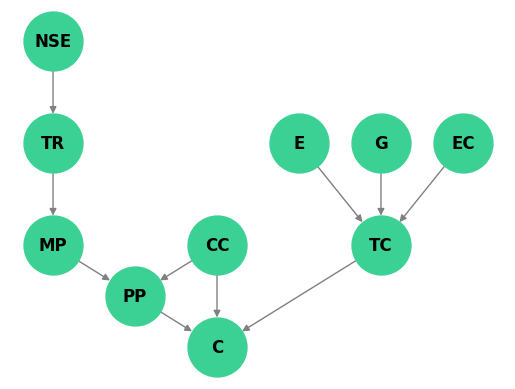

In [62]:
pos = {'NSE': (1, 1), 'TR': (1, 0), 'MP': (1, -1), 'PP': (1.5, -1.5), 'CC': (2, -1), 'E': (2.5, 0),'G': (3, 0),'EC': (3.5, 0),'TC': (3, -1),'C': (2, -2)}

nx.draw_networkx(model, pos=pos, with_labels=True, node_color='#3cd194',
                 node_size=1800, font_size=12, font_weight='bold', edge_color='gray')

plt.axis('off')
plt.show()

## 2.3. Aprendizaje de parámetros

In [130]:
pe = ParameterEstimator(model, df_modelo)

### 2.3.1. Frecuencia de estados

In [129]:
# 1. NSE: Nivel socioeconómico (Incondicional)
print(pe.state_counts('NSE'))

      NSE
0  180269
1  447575
2  295641
3   55556
4   11351


In [65]:
# 2. E: Edad (Incondicional)
print(pe.state_counts('E'))

        E
0    8247
1  261838
2  320229
3  227152
4  172926


In [66]:
# 3. G: Género (Incondicional)
print(pe.state_counts('G'))

        G
0  397432
1  592960


In [67]:
# 4. EC: Estado civil (Incondicional)
print(pe.state_counts('EC'))

       EC
0  581322
1  409070


In [68]:
# 5. TR: Tiene o no tarjeta del retail (Condicional)
print(pe.state_counts('TR'))

NSE       0       1       2      3     4
TR                                      
0     72371  172164  126285  27136  5990
1    107898  275411  169356  28420  5361


In [69]:
# 6. TC: Tipo de cliente (Condicional)
print(pe.state_counts('TC'))

E      0                    1                          2                       \
EC     0         1          0            1             0             1          
G      0     1   0   1      0      1     0      1      0      1      0      1   
TC                                                                              
0   1984  3307   6  23  63538  95850  4496  10922  54271  77219  26081  45386   
1   1435  1455  12  25  38748  38635  3322   6327  36774  36967  19178  24353   

E       3                          4                       
EC      0             1            0             1         
G       0      1      0      1     0      1      0      1  
TC                                                         
0   17180  34674  30547  52733  4524  18050  22021  48474  
1   14912  21603  25799  29704  5656  14540  26948  32713  


In [70]:
# 7. MP: Método de pago (Condicional)
print(pe.state_counts('MP'))

TR       0       1
MP                
0   377676  288425
1    26270  298021


In [71]:
# 8. PP: Producto en promoción o no (Condicional)
print(pe.state_counts('PP'))

CC       0              1       
MP       0       1      0      1
PP                              
0   580214  199949  73406  78375
1     8744   28316   3737  17651


In [72]:
# 9. CC: Canal de compra tienda / web (Incondicional)
print(pe.state_counts('CC'))

       CC
0  817223
1  173169


In [73]:
# 10. C: Compra (Condicional)
print(pe.state_counts('C'))

CC       0                           1                    
PP       0              1            0             1      
TC       0       1      0     1      0      1      0     1
C                                                         
0   206831  210555   8149  3773  27691  12711   2058   552
1   104249   68459   6968  1867  22244   6314   2682   410
2   133439   56630  14172  2131  68243  14578  14560  1126


### 2.3.2. Maxima Verosimilitud

In [74]:
mle = MaximumLikelihoodEstimator(model, df_modelo)

In [75]:
# 1. NSE: Nivel socioeconómico
print(mle.estimate_cpd('NSE'))

+--------+-----------+
| NSE(0) | 0.182018  |
+--------+-----------+
| NSE(1) | 0.451917  |
+--------+-----------+
| NSE(2) | 0.298509  |
+--------+-----------+
| NSE(3) | 0.056095  |
+--------+-----------+
| NSE(4) | 0.0114611 |
+--------+-----------+


In [76]:
# 2. E: Edad
print(mle.estimate_cpd('E'))

+------+------------+
| E(0) | 0.00832701 |
+------+------------+
| E(1) | 0.264378   |
+------+------------+
| E(2) | 0.323336   |
+------+------------+
| E(3) | 0.229356   |
+------+------------+
| E(4) | 0.174604   |
+------+------------+


In [77]:
# 3. G: Género
print(mle.estimate_cpd('G'))

+------+----------+
| G(0) | 0.401288 |
+------+----------+
| G(1) | 0.598712 |
+------+----------+


In [78]:
# 4. EC: Estado civil
print(mle.estimate_cpd('EC'))

+-------+----------+
| EC(0) | 0.586962 |
+-------+----------+
| EC(1) | 0.413038 |
+-------+----------+


In [79]:
# 5. TR: Tiene o no tarjeta del retail
cpd_tr = mle.estimate_cpd('TR')
print(cpd_tr)

+-------+---------------------+-----+---------------------+
| NSE   | NSE(0)              | ... | NSE(4)              |
+-------+---------------------+-----+---------------------+
| TR(0) | 0.40146114972624247 | ... | 0.5277068099726896  |
+-------+---------------------+-----+---------------------+
| TR(1) | 0.5985388502737575  | ... | 0.47229319002731035 |
+-------+---------------------+-----+---------------------+


In [80]:
for i in range(0, len(cpd_tr.values)):
  for j in range(0, len(cpd_tr.values[i])):
    print('tr_',i,'nse_',j,': ',cpd_tr.values[i][j])

tr_ 0 nse_ 0 :  0.40146114972624247
tr_ 0 nse_ 1 :  0.3846595542646484
tr_ 0 nse_ 2 :  0.4271565851827047
tr_ 0 nse_ 3 :  0.48844409244726045
tr_ 0 nse_ 4 :  0.5277068099726896
tr_ 1 nse_ 0 :  0.5985388502737575
tr_ 1 nse_ 1 :  0.6153404457353516
tr_ 1 nse_ 2 :  0.5728434148172953
tr_ 1 nse_ 3 :  0.5115559075527396
tr_ 1 nse_ 4 :  0.47229319002731035


In [81]:
# 6. TC: Tipo de cliente (Condicional)
cpd_tc = mle.estimate_cpd('TC')
print(cpd_tc)

+-------+--------------------+-----+---------------------+
| E     | E(0)               | ... | E(4)                |
+-------+--------------------+-----+---------------------+
| EC    | EC(0)              | ... | EC(1)               |
+-------+--------------------+-----+---------------------+
| G     | G(0)               | ... | G(1)                |
+-------+--------------------+-----+---------------------+
| TC(0) | 0.5802866335185727 | ... | 0.5970660327392316  |
+-------+--------------------+-----+---------------------+
| TC(1) | 0.4197133664814273 | ... | 0.40293396726076836 |
+-------+--------------------+-----+---------------------+


In [82]:
for i in range(0, len(cpd_tc.values)):
  for j in range(0, len(cpd_tc.values[i])):
    for k in range(0, len(cpd_tc.values[i][j])):
      for l in range(0, len(cpd_tc.values[i][j][k])):
        print('tc_',i,'e_',j,'ec_',k,'g_',l,': ',cpd_tc.values[i][j][k][l])

tc_ 0 e_ 0 ec_ 0 g_ 0 :  0.5802866335185727
tc_ 0 e_ 0 ec_ 0 g_ 1 :  0.6944561108777825
tc_ 0 e_ 0 ec_ 1 g_ 0 :  0.3333333333333333
tc_ 0 e_ 0 ec_ 1 g_ 1 :  0.4791666666666667
tc_ 0 e_ 1 ec_ 0 g_ 0 :  0.6211798291066226
tc_ 0 e_ 1 ec_ 0 g_ 1 :  0.7127188905825929
tc_ 0 e_ 1 ec_ 1 g_ 0 :  0.5750831414684062
tc_ 0 e_ 1 ec_ 1 g_ 1 :  0.6331961273117283
tc_ 0 e_ 2 ec_ 0 g_ 0 :  0.5960898456807073
tc_ 0 e_ 2 ec_ 0 g_ 1 :  0.6762562836074475
tc_ 0 e_ 2 ec_ 1 g_ 0 :  0.576261075145275
tc_ 0 e_ 2 ec_ 1 g_ 1 :  0.6507979753079338
tc_ 0 e_ 3 ec_ 0 g_ 0 :  0.5353359092608749
tc_ 0 e_ 3 ec_ 0 g_ 1 :  0.6161309238232315
tc_ 0 e_ 3 ec_ 1 g_ 0 :  0.5421325382458382
tc_ 0 e_ 3 ec_ 1 g_ 1 :  0.639676358916506
tc_ 0 e_ 4 ec_ 0 g_ 0 :  0.4444007858546169
tc_ 0 e_ 4 ec_ 0 g_ 1 :  0.5538508745013808
tc_ 0 e_ 4 ec_ 1 g_ 0 :  0.4496926627049766
tc_ 0 e_ 4 ec_ 1 g_ 1 :  0.5970660327392316
tc_ 1 e_ 0 ec_ 0 g_ 0 :  0.4197133664814273
tc_ 1 e_ 0 ec_ 0 g_ 1 :  0.3055438891222176
tc_ 1 e_ 0 ec_ 1 g_ 0 :  0.6666666

In [83]:
# 7. MP: Método de pago
print(mle.estimate_cpd('MP'))

+-------+---------------------+---------------------+
| TR    | TR(0)               | TR(1)               |
+-------+---------------------+---------------------+
| MP(0) | 0.9349665549355607  | 0.49181851355453016 |
+-------+---------------------+---------------------+
| MP(1) | 0.06503344506443931 | 0.5081814864454698  |
+-------+---------------------+---------------------+


In [84]:
# 8. PP: Producto en promoción o no
cpd_pp = mle.estimate_cpd('PP')
print(cpd_pp)

+-------+----------------------+-----+---------------------+
| CC    | CC(0)                | ... | CC(1)               |
+-------+----------------------+-----+---------------------+
| MP    | MP(0)                | ... | MP(1)               |
+-------+----------------------+-----+---------------------+
| PP(0) | 0.9851534404830226   | ... | 0.8161851998417096  |
+-------+----------------------+-----+---------------------+
| PP(1) | 0.014846559516977442 | ... | 0.18381480015829046 |
+-------+----------------------+-----+---------------------+


In [85]:
for i in range(0, len(cpd_pp.values)):
  for j in range(0, len(cpd_pp.values[i])):
    for k in range(0, len(cpd_pp.values[i][j])):
        print('pp_',i,'cc_',j,'mp_',k,': ',cpd_pp.values[i][j][k])

pp_ 0 cc_ 0 mp_ 0 :  0.9851534404830226
pp_ 0 cc_ 0 mp_ 1 :  0.8759511970735767
pp_ 0 cc_ 1 mp_ 0 :  0.9515574971157461
pp_ 0 cc_ 1 mp_ 1 :  0.8161851998417096
pp_ 1 cc_ 0 mp_ 0 :  0.014846559516977442
pp_ 1 cc_ 0 mp_ 1 :  0.12404880292642323
pp_ 1 cc_ 1 mp_ 0 :  0.04844250288425392
pp_ 1 cc_ 1 mp_ 1 :  0.18381480015829046


In [86]:
# 9. CC: Canal de compra tienda / web
print(mle.estimate_cpd('CC'))

+-------+----------+
| CC(0) | 0.825151 |
+-------+----------+
| CC(1) | 0.174849 |
+-------+----------+


In [87]:
# 10. C: Compra
cpd_c = mle.estimate_cpd('C')
print(cpd_c)

+------+---------------------+-----+---------------------+
| CC   | CC(0)               | ... | CC(1)               |
+------+---------------------+-----+---------------------+
| PP   | PP(0)               | ... | PP(1)               |
+------+---------------------+-----+---------------------+
| TC   | TC(0)               | ... | TC(1)               |
+------+---------------------+-----+---------------------+
| C(0) | 0.4652916973177749  | ... | 0.26436781609195403 |
+------+---------------------+-----+---------------------+
| C(1) | 0.23452090911749554 | ... | 0.19636015325670497 |
+------+---------------------+-----+---------------------+
| C(2) | 0.3001873935647295  | ... | 0.539272030651341   |
+------+---------------------+-----+---------------------+


In [88]:
for i in range(0, len(cpd_c.values)):
  for j in range(0, len(cpd_c.values[i])):
    for k in range(0, len(cpd_c.values[i][j])):
      for l in range(0, len(cpd_c.values[i][j][k])):
        print('c_',i,'cc_',j,'pp_',k,'tc_',l,': ',cpd_c.values[i][j][k][l])

c_ 0 cc_ 0 pp_ 0 tc_ 0 :  0.4652916973177749
c_ 0 cc_ 0 pp_ 0 tc_ 1 :  0.6273164424211367
c_ 0 cc_ 0 pp_ 1 tc_ 0 :  0.2782273208371744
c_ 0 cc_ 0 pp_ 1 tc_ 1 :  0.485523098700296
c_ 0 cc_ 1 pp_ 0 tc_ 0 :  0.23431603174871804
c_ 0 cc_ 1 pp_ 0 tc_ 1 :  0.37826979733952326
c_ 0 cc_ 1 pp_ 1 tc_ 0 :  0.1066321243523316
c_ 0 cc_ 1 pp_ 1 tc_ 1 :  0.26436781609195403
c_ 1 cc_ 0 pp_ 0 tc_ 0 :  0.23452090911749554
c_ 1 cc_ 0 pp_ 0 tc_ 1 :  0.2039631275994804
c_ 1 cc_ 0 pp_ 1 tc_ 0 :  0.23790501553484245
c_ 1 cc_ 0 pp_ 1 tc_ 1 :  0.24025221979153263
c_ 1 cc_ 1 pp_ 0 tc_ 0 :  0.18822454263906988
c_ 1 cc_ 1 pp_ 0 tc_ 1 :  0.18789988989078357
c_ 1 cc_ 1 pp_ 1 tc_ 0 :  0.13896373056994818
c_ 1 cc_ 1 pp_ 1 tc_ 1 :  0.19636015325670497
c_ 2 cc_ 0 pp_ 0 tc_ 0 :  0.3001873935647295
c_ 2 cc_ 0 pp_ 0 tc_ 1 :  0.1687204299793829
c_ 2 cc_ 0 pp_ 1 tc_ 0 :  0.4838676636279832
c_ 2 cc_ 0 pp_ 1 tc_ 1 :  0.2742246815081714
c_ 2 cc_ 1 pp_ 0 tc_ 0 :  0.5774594256122121
c_ 2 cc_ 1 pp_ 0 tc_ 1 :  0.4338303127696932
c

### 2.3.2. Estimar los parámetros bayesianos

In [89]:
be = BayesianEstimator(model, df_modelo)

In [90]:
# 1. NSE: Nivel socioeconómico
cpd_nse = be.estimate_cpd('NSE', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_nse)

+--------+-----------+
| NSE(0) | 0.182018  |
+--------+-----------+
| NSE(1) | 0.451914  |
+--------+-----------+
| NSE(2) | 0.298508  |
+--------+-----------+
| NSE(3) | 0.0560964 |
+--------+-----------+
| NSE(4) | 0.011463  |
+--------+-----------+


In [91]:
# 2. E: Edad
cpd_e = be.estimate_cpd('E', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_e)

+------+------------+
| E(0) | 0.00832894 |
+------+------------+
| E(1) | 0.264377   |
+------+------------+
| E(2) | 0.323334   |
+------+------------+
| E(3) | 0.229355   |
+------+------------+
| E(4) | 0.174604   |
+------+------------+


In [92]:
# 3. G: Género
cpd_g = be.estimate_cpd('G', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_g)

+------+----------+
| G(0) | 0.401289 |
+------+----------+
| G(1) | 0.598711 |
+------+----------+


In [93]:
# 4. EC: Estado civil
cpd_ec = be.estimate_cpd('EC', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_ec)

+-------+----------+
| EC(0) | 0.586961 |
+-------+----------+
| EC(1) | 0.413039 |
+-------+----------+


In [94]:
# 5. TR: Tiene o no tarjeta del retail
cpd_tr = be.estimate_cpd('TR', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_tr)

+-------+--------------------+-----+--------------------+
| NSE   | NSE(0)             | ... | NSE(4)             |
+-------+--------------------+-----+--------------------+
| TR(0) | 0.4014622429564378 | ... | 0.5277019290055492 |
+-------+--------------------+-----+--------------------+
| TR(1) | 0.5985377570435622 | ... | 0.4722980709944508 |
+-------+--------------------+-----+--------------------+


In [95]:
# 6. TC: Tipo de cliente (Condicional)
cpd_tc = be.estimate_cpd('TC', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_tc)

+-------+--------------------+-----+--------------------+
| E     | E(0)               | ... | E(4)               |
+-------+--------------------+-----+--------------------+
| EC    | EC(0)              | ... | EC(1)              |
+-------+--------------------+-----+--------------------+
| G     | G(0)               | ... | G(1)               |
+-------+--------------------+-----+--------------------+
| TC(0) | 0.5802748939903495 | ... | 0.5970654349499616 |
+-------+--------------------+-----+--------------------+
| TC(1) | 0.4197251060096505 | ... | 0.4029345650500385 |
+-------+--------------------+-----+--------------------+


In [96]:
# 7. MP: Método de pago
cpd_mp = be.estimate_cpd('MP', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_mp)

+-------+---------------------+---------------------+
| TR    | TR(0)               | TR(1)               |
+-------+---------------------+---------------------+
| MP(0) | 0.9349611710331204  | 0.49181858330875045 |
+-------+---------------------+---------------------+
| MP(1) | 0.06503882896687965 | 0.5081814166912496  |
+-------+---------------------+---------------------+


In [97]:
# 8. PP: Producto en promoción o no
cpd_pp = be.estimate_cpd('PP', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_pp)

+-------+----------------------+-----+--------------------+
| CC    | CC(0)                | ... | CC(1)              |
+-------+----------------------+-----+--------------------+
| MP    | MP(0)                | ... | MP(1)              |
+-------+----------------------+-----+--------------------+
| PP(0) | 0.9851513811197865   | ... | 0.8161769682958705 |
+-------+----------------------+-----+--------------------+
| PP(1) | 0.014848618880213528 | ... | 0.1838230317041295 |
+-------+----------------------+-----+--------------------+


In [98]:
# 9. CC: Canal de compra tienda / web
cpd_cc = be.estimate_cpd('CC', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_cc)

+-------+----------+
| CC(0) | 0.825148 |
+-------+----------+
| CC(1) | 0.174852 |
+-------+----------+


In [99]:
# 10. C: Compra
cpd_c = be.estimate_cpd('C', prior_type='BDeu', equivalent_sample_size=10)
print(cpd_c)

+------+---------------------+-----+---------------------+
| CC   | CC(0)               | ... | CC(1)               |
+------+---------------------+-----+---------------------+
| PP   | PP(0)               | ... | PP(1)               |
+------+---------------------+-----+---------------------+
| TC   | TC(0)               | ... | TC(1)               |
+------+---------------------+-----+---------------------+
| C(0) | 0.46529132624816677 | ... | 0.26440907821786125 |
+------+---------------------+-----+---------------------+
| C(1) | 0.23452118698004573 | ... | 0.19644210442343746 |
+------+---------------------+-----+---------------------+
| C(2) | 0.30018748677178747 | ... | 0.5391488173587013  |
+------+---------------------+-----+---------------------+


In [132]:
model.fit(df_modelo, estimator=BayesianEstimator, prior_type='BDeu')

In [133]:
for cpd in model.get_cpds():
    print(cpd)

+--------+-----------+
| NSE(0) | 0.182018  |
+--------+-----------+
| NSE(1) | 0.451916  |
+--------+-----------+
| NSE(2) | 0.298509  |
+--------+-----------+
| NSE(3) | 0.0560957 |
+--------+-----------+
| NSE(4) | 0.0114621 |
+--------+-----------+
+-------+---------------------+-----+--------------------+
| NSE   | NSE(0)              | ... | NSE(4)             |
+-------+---------------------+-----+--------------------+
| TR(0) | 0.40146169634437234 | ... | 0.5277043692741367 |
+-------+---------------------+-----+--------------------+
| TR(1) | 0.5985383036556277  | ... | 0.4722956307258633 |
+-------+---------------------+-----+--------------------+
+-------+---------------------+---------------------+
| TR    | TR(0)               | TR(1)               |
+-------+---------------------+---------------------+
| MP(0) | 0.9349638629676803  | 0.49181854843178896 |
+-------+---------------------+---------------------+
| MP(1) | 0.06503613703231971 | 0.508181451568211   |
+-------+-

## 2.4. Aprendizaje estructurado

### 2.4.1. Ingeniería de características

In [100]:
X = (df_modelo.iloc[:, :-1])
X.head()

,NSE,E,G,EC,TR,TC,MP,PP,CC
0,2,1,0,1,0,1,0,0,0
1,1,2,1,1,0,1,0,0,0
2,1,1,1,0,1,1,1,0,0
3,2,2,0,1,0,0,0,0,0
4,1,2,1,0,1,0,0,0,0


In [101]:
y = (df_modelo.iloc[:, -1])
y.head()

0    0
1    2
2    1
3    0
4    2
Name: C, dtype: int64

In [102]:
# Seleccionar las 8 mejores variables
skb = SelectKBest(score_func=chi2, k=8)
f_best = skb.fit_transform(X, y)

top_features = sorted(zip(list(X.columns), skb.scores_), key=lambda x: x[1], reverse=True)
top_features

[('CC', 58135.64001704063),
 ('MP', 47965.17440914534),
 ('TC', 27652.95955955039),
 ('PP', 17308.3507386778),
 ('TR', 10222.724289715414),
 ('NSE', 2549.0238945347473),
 ('E', 777.1622315463358),
 ('EC', 67.32377520270178),
 ('G', 29.85555134650568)]

In [104]:
data = pd.DataFrame(df_modelo, columns=[i[0] for i in top_features[:skb.k]])
data[df_modelo.columns[-1]] = y
data.head()

,CC,MP,TC,PP,TR,NSE,E,EC,C
0,0,0,1,0,0,2,1,1,0
1,0,0,1,0,0,1,2,1,2
2,0,1,1,0,1,1,1,0,1
3,0,0,0,0,0,2,2,1,0
4,0,0,0,0,1,1,2,0,2


In [107]:
# probbabilidad conjunta
joint_probability = data.groupby([data.columns], axis=1).size()/data.shape[0]
pd.DataFrame(joint_probability)

,0
C,0.000001
CC,0.000001
E,0.000001
EC,0.000001
MP,0.000001
NSE,0.000001
PP,0.000001
TC,0.000001
TR,0.000001


### 2.4.2. Grafico aciciclo dirigido

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

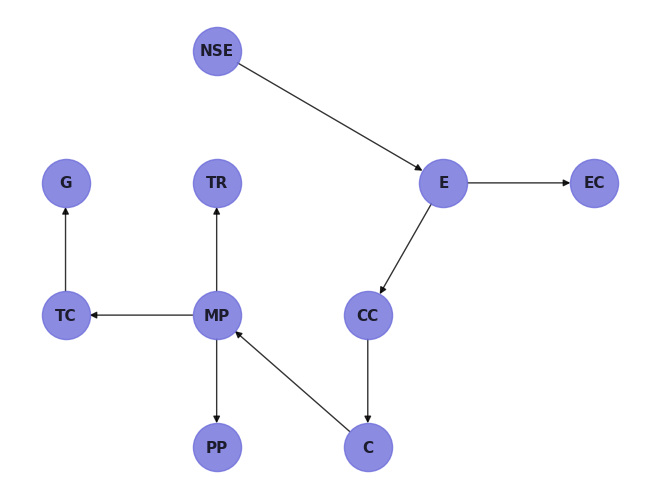

In [124]:
ts = TreeSearch(df_modelo, root_node='NSE')
dag = ts.estimate(estimator_type='chow-liu')
pos = {'NSE': (1, 1), 'TR': (1, 0), 'MP': (1, -1), 'PP': (1, -2), 'CC': (2, -1), 'E': (2.5, 0),'G': (0, 0),'EC': (3.5, 0),'TC': (0, -1),'C': (2, -2)}
nx.draw(dag, pos=pos, with_labels=True, node_size=1200, node_color='#6e6edb', font_size=11, font_weight='bold', alpha=0.8)
plt.show()

### 2.4.3. CPDs

In [126]:
bn = BayesianNetwork(dag)
bn.fit(df_modelo)

for i in data.columns:
  print(i,'\n',bn.get_cpds(i),'\n')

CC 
 +-------+---------------------+-----+---------------------+
| E     | E(0)                | ... | E(4)                |
+-------+---------------------+-----+---------------------+
| CC(0) | 0.7331150721474475  | ... | 0.9156980442501417  |
+-------+---------------------+-----+---------------------+
| CC(1) | 0.26688492785255247 | ... | 0.08430195574985833 |
+-------+---------------------+-----+---------------------+ 

MP 
 +-------+--------------------+---------------------+--------------------+
| C     | C(0)               | C(1)                | C(2)               |
+-------+--------------------+---------------------+--------------------+
| MP(0) | 0.7896045054200542 | 0.6618275459325588  | 0.4987486839041062 |
+-------+--------------------+---------------------+--------------------+
| MP(1) | 0.2103954945799458 | 0.33817245406744123 | 0.5012513160958938 |
+-------+--------------------+---------------------+--------------------+ 

TC 
 +-------+---------------------+------------

# Inferencias

In [135]:
inference = VariableElimination(model)

1. ¿Cuál es la probabilidad de contar con un cliente en el nivel socioeconómico A y otro cliente en el E? (marginal)

In [146]:
p_nse = inference.query(variables=['NSE'])
print(p_nse)
print('\nLa probabilidad de que un cliente sea del NSE A es del ',round(p_nse.values[0]*100,2), "%")
print('\nLa probabilidad de que un cliente sea del NSE E es del ',round(p_nse.values[4]*100,2), "%")

+--------+------------+
| NSE    |   phi(NSE) |
+========+============+
| NSE(0) |     0.1820 |
+--------+------------+
| NSE(1) |     0.4519 |
+--------+------------+
| NSE(2) |     0.2985 |
+--------+------------+
| NSE(3) |     0.0561 |
+--------+------------+
| NSE(4) |     0.0115 |
+--------+------------+

La probabilidad de que un cliente sea del NSE A es del  18.2 %

La probabilidad de que un cliente sea del NSE E es del  1.15 %


2. ¿Cuál es la probabilidad de que un cliente se encuentre en una edad entre 36 y 45 años? (marginal)

In [148]:
p_e = inference.query(variables=['E'])
print(p_e)
print('\nLa probabilidad de que un cliente tenga entre 36-45 años es del ',round(p_e.values[2]*100,2), "%")

+------+----------+
| E    |   phi(E) |
+======+==========+
| E(0) |   0.0083 |
+------+----------+
| E(1) |   0.2644 |
+------+----------+
| E(2) |   0.3233 |
+------+----------+
| E(3) |   0.2294 |
+------+----------+
| E(4) |   0.1746 |
+------+----------+

La probabilidad de que un cliente tenga entre 36-45 años es del  32.33 %


3. ¿Cuáles son las probabilidades de que una persona del nivel socioeconómico A, B, C, D o E cuente con una tarjeta del retail? (condicional)

In [156]:
nse_list = ['A', 'B', 'C', 'D','E']

for index,value in enumerate(nse_list):
  p_nse_tr = inference.query(variables=['TR'], evidence={'NSE':index})
  print(p_nse_tr)
  print('\nLa probabilidad de que un cliente de NSE ',value,' tenga tarjeta del retail es del ',round(p_nse_tr.values[1]*100,2), '%\n')

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.4015 |
+-------+-----------+
| TR(1) |    0.5985 |
+-------+-----------+

La probabilidad de que un cliente de NSE  A  tenga tarjeta del retail es del  59.85 %

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.3847 |
+-------+-----------+
| TR(1) |    0.6153 |
+-------+-----------+

La probabilidad de que un cliente de NSE  B  tenga tarjeta del retail es del  61.53 %

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.4272 |
+-------+-----------+
| TR(1) |    0.5728 |
+-------+-----------+

La probabilidad de que un cliente de NSE  C  tenga tarjeta del retail es del  57.28 %

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.4884 |
+-------+-----------+
| TR(1) |    0.5116 |
+-------+-----------+

La probabilidad de que un cliente de NSE  D  tenga tarjeta del retail es del  51.16 %

+-------+-----------+
| TR    | 

4. ¿Cuál es la probabilidad de que un cliente que tiene tarjeta del retail la use? (condicional)

In [158]:
p_mp_tr = inference.query(variables=['MP'], evidence={'TR':1})
print(p_mp_tr)
print('\nLa probabilidad de que un cliente que tiene tarjeta del retail lo use como medio de pago es del ',round(p_mp_tr.values[1]*100,2), "%")

+-------+-----------+
| MP    |   phi(MP) |
+=======+===========+
| MP(0) |    0.4918 |
+-------+-----------+
| MP(1) |    0.5082 |
+-------+-----------+

La probabilidad de que un cliente que tiene tarjeta del retail lo use como médio de pago es del  50.82 %


5. ¿Cuál es la probabilidad de que los clientes con una edad entre 36 y 45 años sean nuevos? (condicional)

In [161]:
p_tp_e = inference.query(variables=['TC'], evidence={'E':2})
print(p_tp_e)
print('\nLa probabilidad de que un cliente que tiene entre 36 y 45 años sea nuevo es del',round(p_tp_e.values[0]*100,2), "%")

+-------+-----------+
| TC    |   phi(TC) |
+=======+===========+
| TC(0) |    0.6345 |
+-------+-----------+
| TC(1) |    0.3655 |
+-------+-----------+

La probabilidad de que un cliente que tiene entre 36 y 45 años sea nuevo es del 63.45 %


6. ¿Cuál es la probabilidad de que un cliente que compró através del canal de compra tienda física tenga un monto de compra alto? (condicional)

In [162]:
p_c_cc = inference.query(variables=['C'], evidence={'CC':0})
print(p_c_cc)
print('\nLa probabilidad de que un cliente que compró en una tienda física tenga un monto de compra alto es del',round(p_c_cc.values[2]*100,2), "%")

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5203 |
+------+----------+
| C(1) |   0.2234 |
+------+----------+
| C(2) |   0.2564 |
+------+----------+

La probabilidad de que un cliente que compró en una tienda física tenga un monto de compra alto es del 25.64 %


7. ¿Cuál es la probabilidad de que un cliente de género masculino, con estado civil soltero y con una edad entre 26 y 35 años vuelva a comprar ? (conjunta)

In [163]:
p_tc_gece = inference.query(variables=['TC'], evidence={'G':0,'EC':0,'E':1})
print(p_tc_gece)
print('\nLa probabilidad de que un cliente de género masculino, con estado civil soltero y con una edad entre 26 y 35 años vuelva a comprar es del',round(p_tc_gece.values[1]*100,2), "%")

+-------+-----------+
| TC    |   phi(TC) |
+=======+===========+
| TC(0) |    0.6212 |
+-------+-----------+
| TC(1) |    0.3788 |
+-------+-----------+

La probabilidad de que un cliente de género masculino, con estado civil soltero y con una edad entre 26 y 35 años vuelva a comprar es del 37.88 %


8. ¿Cuál es la probabilidad de que un cliente de nivel socioeconómico B con tarjeta de retail y con una edad entre 36 a 45 años realicé una compra con un rango de gasto medio? (conjunta)

In [164]:
p_c_nte = inference.query(variables=['TC'], evidence={'NSE':1,'TR':1,'E':2})
print(p_c_nte)
print('\nLa probabilidad de que un cliente de NSE B con tarjeta de retail y con una edad entre 36 a 45 años realicé una compra con un rango de gasto medio es del',round(p_c_nte.values[1]*100,2), "%")

+-------+-----------+
| TC    |   phi(TC) |
+=======+===========+
| TC(0) |    0.6345 |
+-------+-----------+
| TC(1) |    0.3655 |
+-------+-----------+

La probabilidad de que un cliente de NSE B con tarjeta de retail y con una edad entre 36 a 45 años realicé una compra con un rango de gasto medio es del 36.55 %


# Predicciones

In [167]:
test = np.squeeze(df_modelo.iloc[:, -1].values)
pred = df_modelo.iloc[:, :-1]

y_pred = model.predict(pred)
print(accuracy_score(np.squeeze(y_pred.values), test))

  0%|          | 0/2559 [00:00<?, ?it/s]

0.5390168741266085


In [168]:
y_pred_ = bn.predict(pred)
print(accuracy_score(np.squeeze(y_pred_.values), test))

  0%|          | 0/2559 [00:00<?, ?it/s]

0.5391955912406401
